# 時系列解析3
https://www.procrasist.com/entry/12-time-series

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
# 以下のコードの方が読み込みは簡単
data = pd.read_csv('AirPassengers.csv', 
                   index_col='Month', 
                   parse_dates=True, 
                   dtype='float')
data.head()

# 日付形式にする
df = data['#Passengers'] 
df.head()

Month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
Name: #Passengers, dtype: float64

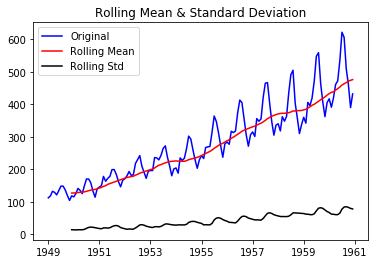

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (10%)            -2.578770
Critical Value (5%)             -2.884042
dtype: float64


In [3]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
#     dftest = adfuller(timeseries, autolag='AIC')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

array = df.values
test_stationarity(df)

## 定常性のチェック  
平均や分散がずっと一定ならstarionary(定常)といえる。  
多くの時系列モデルは定常性を仮定しているので、定常性のチェックは重要  

定常性というのは厳格な基準があるが、実務上では下記の要素を定常性の条件としてもよいだろう
- 一定の平均
- 一定の分散
- 時間に依存しない自己共分散

使用しているデータを見ると、増加傾向にあることがわかる  
これだと平均や分散が一定とならないように見える。 ちゃんと調べるために、下記の処理を施してみる  

- moving averageやmoving distanceをとってみる(sliding window)今回は、季節変動的なのも吸収したいから12か月分(上図)
- Dickkey Fuller Testを用いる。定常性の統計検定である(上図)。

p-valueが1に近い　→　単位根がある　→　差分がARMAモデル → ARIMAモデル

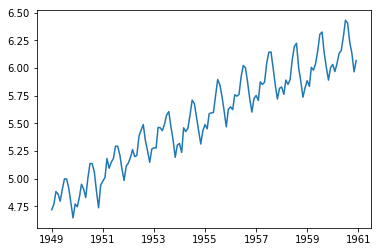

In [4]:
# 1. log
df_log = np.log(df.astype(int))
plt.plot(df.index, df_log)
# df["passengers_sqrt"] = np.sqrt(df.Passengers)
# plt.plot(df.index, df.passengers_sqrt)

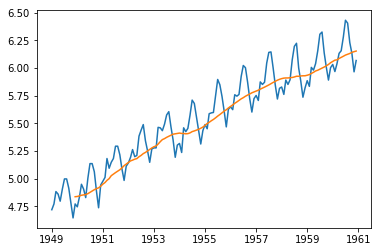

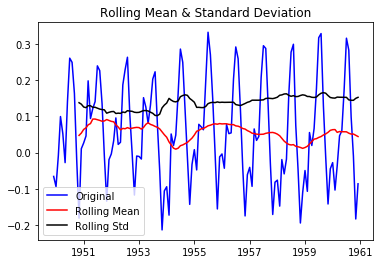

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (10%)            -2.579896
Critical Value (5%)             -2.886151
dtype: float64


In [5]:
# 2. eliminate noise
df_moving_ave = df_log.rolling(window=12).mean()
df_log_ave_diff = df_log - df_moving_ave

plt.plot(df.index, df_log,label="original")
plt.plot(df.index, df_moving_ave,label="moving average")
plt.figure()

timeseries = df_log_ave_diff
test_stationarity(timeseries.dropna())

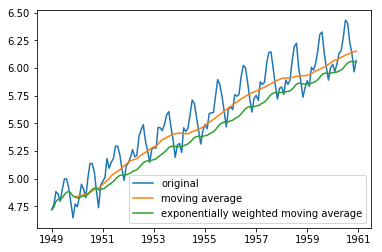

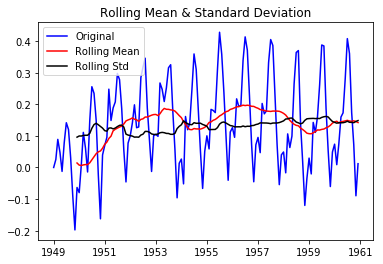

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (10%)            -2.578770
Critical Value (5%)             -2.884042
dtype: float64


In [6]:
df_expweighted_ave = df_log.ewm(halflife=12).mean() #半減の時間 weighted moving average
plt.plot(df.index, df_log,label="original")
plt.plot(df.index, df_moving_ave,label="moving average")
plt.plot(df.index, df_expweighted_ave,label="exponentially weighted moving average")
plt.legend()
plt.figure()
timeseries = df_log - df_expweighted_ave
test_stationarity(timeseries)

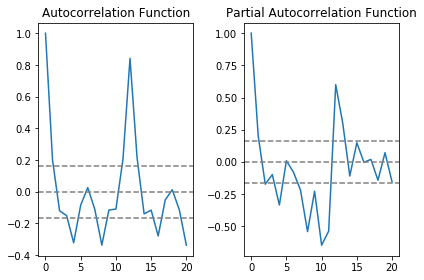

In [7]:
df_log_diff = df_log - df_log.shift()
from statsmodels.tsa.stattools import acf, pacf
ts = df_log_diff.dropna()
lag_acf = acf(ts, nlags=20)
lag_pacf = pacf(ts, nlags=20, method="ols")
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

/Users/mitsuhiro/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/mitsuhiro/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/mitsuhiro/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/scipy/signal/signaltools.py:1364: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/mitsuhiro/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/scipy/signal/signaltools.py:1367: FutureWarning: Using

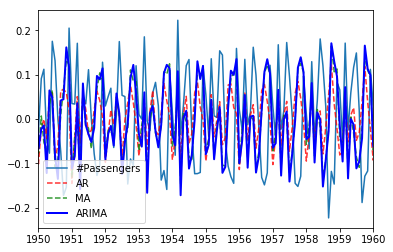

In [8]:
# ARIMA model

from statsmodels.tsa.arima_model import ARIMA
ts = df_log_diff.dropna()
model1 = ARIMA(ts, order=(2, 1, 0))  
results_AR = model1.fit(disp=-1)  
model2 = ARIMA(ts, order=(0, 1, 2))
results_MA = model2.fit(disp=-1)
model3 = ARIMA(ts,order=(2, 1, 2))
results_ARIMA = model3.fit()

plt.plot(ts)
plt.plot(results_AR.fittedvalues,"--", color='red',alpha=0.8,label="AR")
plt.plot(results_MA.fittedvalues,"--", color="green",alpha=0.8,label="MA")
plt.plot(results_ARIMA.fittedvalues,lw=2, color="blue",label="ARIMA")
plt.xlim("1950","1960")
plt.legend()
# plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts)**2))

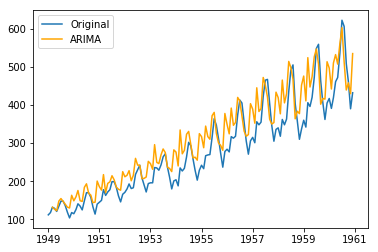

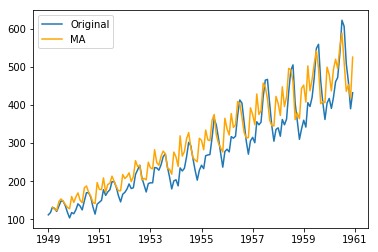

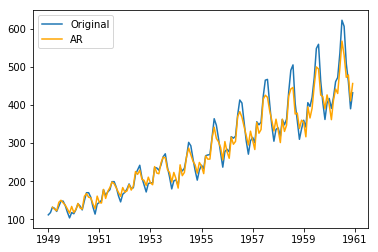

In [9]:
def predict(name, results):
    df_name = pd.Series(results.fittedvalues)
    df_predict_cumsum = df_name.cumsum()
    # 元に戻す
    df_name = df_predict_cumsum.fillna(0)+df_log
    df_name = np.exp(df_name)
    df.head()
    plt.plot(df.index, df, label="Original")
    plt.plot(df.index, df_name,color="orange",label=name)
    plt.legend()
    plt.show()
predict("ARIMA", results_ARIMA)
predict("MA", results_MA)
predict("AR",results_AR)